<a href="https://colab.research.google.com/github/GOPTHREYA000/V.S.Gopthreya_MinorProject/blob/main/Gopthreya_MinorProject_BB84_QKD_Watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantum-Inspired Digital Watermarking for Forensic Evidence Authentication Using BB84 QKD

In [28]:
import os

base_dir = "/content/quantum_watermarking"

folders = [
    "sim",
    "watermark",
    "attacks",
    "eval",
    "samples",
    "docs"
]

for folder in folders:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

print("Project folders created successfully.")


Project folders created successfully.


In [29]:
!ls /content/quantum_watermarking


attacks  docs  eval  main.ipynb  samples  sim  watermark


In [30]:
!tree /content/quantum_watermarking


/bin/bash: line 1: tree: command not found


In [31]:
import os

print("wm.png exists:",
      os.path.exists("/content/quantum_watermarking/samples/wm.png"))

print("samples folder contents:")
!ls /content/quantum_watermarking/samples


wm.png exists: True
samples folder contents:
lena.png  wm.png


In [32]:
import cv2
import numpy as np
from skimage import data
import os

samples_dir = "/content/quantum_watermarking/samples"
os.makedirs(samples_dir, exist_ok=True)

# Host image
host_img = data.astronaut()
host_img = cv2.cvtColor(host_img, cv2.COLOR_RGB2GRAY)
host_img = cv2.resize(host_img, (512, 512))
cv2.imwrite(f"{samples_dir}/lena.png", host_img)

# Watermark image (32x32)
wm_img = np.zeros((32, 32), dtype=np.uint8)
cv2.putText(wm_img, "AUTH", (1, 22),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, 255, 1)
cv2.imwrite(f"{samples_dir}/wm.png", wm_img)


True

In [33]:
!ls /content/quantum_watermarking/samples


lena.png  wm.png


In [34]:
import cv2
import numpy as np

wm = cv2.imread("/content/quantum_watermarking/samples/wm.png", 0)
assert wm is not None, "wm.png failed to load"

_, wm_bin = cv2.threshold(wm, 127, 1, cv2.THRESH_BINARY)
wm_bits = wm_bin.flatten()

print("Watermark bits length:", len(wm_bits))


Watermark bits length: 1024


BB84 key length: 1015
Host shape: (512, 512)
Watermark bits: 1024
Watermark embedded
JPEG attack applied
Watermark extracted
Authentication Status: TAMPERED
Match Score: 0.46153846153846156
Compared bits: 169
PSNR: 140.40870290176412
SSIM: 0.9999999999949049


/tmp/ipython-input-2666688263.py:114: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(host, watermarked)


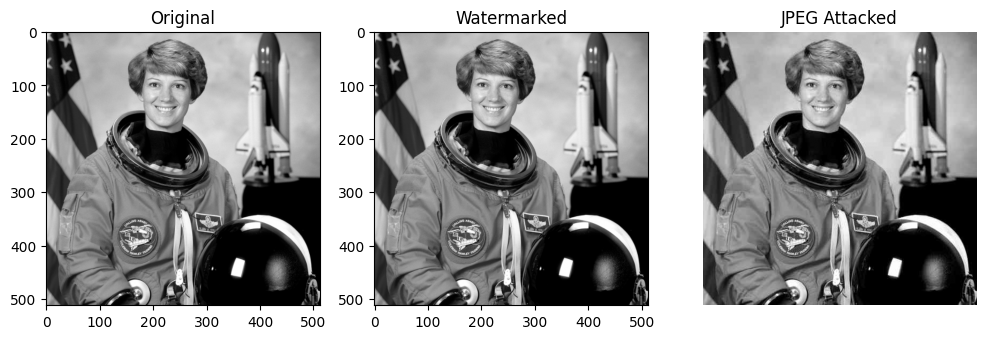

In [35]:
# =========================================================
# ALL-IN-ONE PIPELINE CHECK (NO FILE IMPORTS)
# =========================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -----------------------------
# 1. BB84 Key Generation
# -----------------------------
def bb84_key_generation(n_bits=2048):
    alice_bits = np.random.randint(2, size=n_bits)
    alice_bases = np.random.randint(2, size=n_bits)
    bob_bases   = np.random.randint(2, size=n_bits)

    key = []
    for i in range(n_bits):
        if alice_bases[i] == bob_bases[i]:
            key.append(alice_bits[i])
    return np.array(key)

key = bb84_key_generation()
print("BB84 key length:", len(key))

# -----------------------------
# 2. Load / Create Images
# -----------------------------
# Host image (benchmark)
host = data.astronaut()
host = cv2.cvtColor(host, cv2.COLOR_RGB2GRAY)
host = cv2.resize(host, (512, 512))

# Watermark image (32x32)
wm = np.zeros((32, 32), dtype=np.uint8)
cv2.putText(wm, "AUTH", (1, 22),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, 255, 1)

_, wm_bin = cv2.threshold(wm, 127, 1, cv2.THRESH_BINARY)
wm_bits = wm_bin.flatten()

print("Host shape:", host.shape)
print("Watermark bits:", len(wm_bits))

# -----------------------------
# 3. Embed Watermark (DCT)
# -----------------------------
def embed_watermark(host_img, watermark_bits, key, strength=5):
    dct = cv2.dct(host_img.astype(np.float32))
    idx = 0

    for i in range(20, dct.shape[0], 40):
        for j in range(20, dct.shape[1], 40):
            if idx < len(watermark_bits):
                dct[i, j] += watermark_bits[idx] * key[idx % len(key)] * strength
                idx += 1

    return cv2.idct(dct)

watermarked = embed_watermark(host, wm_bits, key)
print("Watermark embedded")

# -----------------------------
# 4. Attack (JPEG Compression)
# -----------------------------
def jpeg_attack(image, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, enc = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(enc, 0)

attacked = jpeg_attack(watermarked)
print("JPEG attack applied")

# -----------------------------
# 5. Extract Watermark
# -----------------------------
def extract_watermark(image, length):
    dct = cv2.dct(image.astype(np.float32))
    extracted = []
    idx = 0

    for i in range(20, dct.shape[0], 40):
        for j in range(20, dct.shape[1], 40):
            if idx < length:
                extracted.append(1 if dct[i, j] > 0 else 0)
                idx += 1

    return np.array(extracted)

extracted_bits = extract_watermark(attacked, len(wm_bits))
print("Watermark extracted")

# -----------------------------
# 6. Authentication Decision (FIXED)
# -----------------------------
min_len = min(len(wm_bits), len(extracted_bits))

match_score = np.sum(
    wm_bits[:min_len] == extracted_bits[:min_len]
) / min_len

status = "AUTHENTIC" if match_score >= 0.75 else "TAMPERED"

print("Authentication Status:", status)
print("Match Score:", match_score)
print("Compared bits:", min_len)


# -----------------------------
# 7. Quality Metrics
# -----------------------------
psnr = peak_signal_noise_ratio(host, watermarked)
ssim = structural_similarity(
    host,
    watermarked,
    data_range=watermarked.max() - watermarked.min()
)

print("PSNR:", psnr)
print("SSIM:", ssim)

# -----------------------------
# 8. Visual Results
# -----------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(host, cmap="gray")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(watermarked, cmap="gray")
plt.title("Watermarked")

plt.subplot(1,3,3)
plt.imshow(attacked, cmap="gray")
plt.title("JPEG Attacked")

plt.axis("off")
plt.show()


In [36]:
import sys
sys.path.append("/content/quantum_watermarking")

from sim.bb84 import bb84_key_generation

key = bb84_key_generation(2048)
print("Quantum key length:", len(key))


Quantum key length: 996


In [37]:
import cv2
import numpy as np

host = cv2.imread("/content/quantum_watermarking/samples/lena.png", 0)
wm = cv2.imread("/content/quantum_watermarking/samples/wm.png", 0)

assert host is not None, "Host image not found"
assert wm is not None, "Watermark image not found"

_, wm_bin = cv2.threshold(wm, 127, 1, cv2.THRESH_BINARY)
wm_bits = wm_bin.flatten()

print("Host shape:", host.shape)
print("Watermark bits:", len(wm_bits))


Host shape: (512, 512)
Watermark bits: 1024


In [38]:
from watermark.embed import embed_watermark

watermarked_img = embed_watermark(host, wm_bits, key)

cv2.imwrite(
    "/content/quantum_watermarking/samples/watermarked.png",
    watermarked_img
)

print("Watermark embedded and saved.")


Watermark embedded and saved.


In [39]:
from attacks.attacks import jpeg_attack, noise_attack, crop_attack

jpeg_img = jpeg_attack(watermarked_img)
noise_img = noise_attack(watermarked_img)
crop_img = crop_attack(watermarked_img)

print("Attacks applied.")


Attacks applied.


In [40]:
from watermark.extract import extract_watermark

extracted_bits = extract_watermark(jpeg_img, len(wm_bits))

print("Extracted watermark length:", len(extracted_bits))


Extracted watermark length: 169


In [41]:
# Fix for capacity mismatch
min_len = min(len(wm_bits), len(extracted_bits))

match_score = np.sum(
    wm_bits[:min_len] == extracted_bits[:min_len]
) / min_len

if match_score >= 0.75:
    status = "AUTHENTIC"
else:
    status = "TAMPERED"

print("Authentication Status:", status)
print("Match Score:", match_score)
print("Compared bits:", min_len)


Authentication Status: TAMPERED
Match Score: 0.46153846153846156
Compared bits: 169


In [42]:
from eval.metrics import evaluate

psnr, ssim = evaluate(host, watermarked_img)

print("PSNR:", psnr)
print("SSIM:", ssim)


PSNR: 140.40870705976522
SSIM: 0.9999988576094575


In [50]:
!python /content/quantum_watermarking/tests/robustness_tests.py


[ WARN:0@1.078] global loadsave.cpp:1617 imencodeWithMetadata Unsupported depth image for selected encoder is fallbacked to CV_8U.
Traceback (most recent call last):
  File "/content/quantum_watermarking/tests/robustness_tests.py", line 73, in <module>
    psnr, ssim = evaluate(host, img)
                 ^^^^^^^^^^^^^^^^^^^
  File "/content/quantum_watermarking/eval/metrics.py", line 10, in evaluate
    psnr = peak_signal_noise_ratio(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py", line 143, in peak_signal_noise_ratio
    check_shape_equality(image_true, image_test)
  File "/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py", line 627, in check_shape_equality
    raise ValueError('Input images must have the same dimensions.')
ValueError: Input images must have the same dimensions.
